In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

from time import sleep
from IPython.display import clear_output

import collections
import sys

import pandas as pd

In [3]:
class Simulation():
    def __init__(self, top_boundary=100, bottom_boundary=0,
                 left_boundary=0, right_boundary=100, prob_of_attachment=1):
        
        self.prob_of_attachment = prob_of_attachment
        self.env = Environment(self, top_boundary, bottom_boundary,
                               left_boundary, right_boundary)
        
        
    def timestep(self):
        
        # Add walker each time step, until maximum
        if len(self.env.walkers) < self.env.n_walkers:
            self.env.add_walker()
        
        # Let all walkers take a random step         
        for walker in self.env.walkers:
            walker.random_move()

    
class Environment():
    def __init__(self, sim, top_boundary, bottom_boundary, left_boundary, 
                 right_boundary, n_walkers=1):
        self.sim = sim
        self.top_boundary = top_boundary
        self.bottom_boundary = bottom_boundary
        self.left_boundary = left_boundary
        self.right_boundary = right_boundary
        self.n_walkers = n_walkers
        
        self.grid = self.gen_grid()
        
        self.object = Object(self)
        
        self.walkers = []
        self.init_walkers()

    def init_walkers(self):
        self.walkers = [Walker(self, prob_of_attachment=self.sim.prob_of_attachment)]
    
    def add_walker(self):
        self.walkers += [Walker(self, prob_of_attachment=self.sim.prob_of_attachment)]
        
    def gen_grid(self):
        return np.zeros((self.top_boundary, self.right_boundary))
    
    def add_cell(self,cell,cell_type):
        if cell_type == 'walker':
            self.grid[self.top_boundary-cell[1]-1][cell[0]] = 1
        else:
            self.grid[self.top_boundary-cell[1]-1][cell[0]] = 0.5
    
    def delete_cell(self, cell):
        self.grid[self.top_boundary - cell[1] - 1][cell[0]] = 0
    
    def move_cell(self, old_cell, new_cell, cell_type):
        self.grid[self.top_boundary - old_cell[1] - 1][old_cell[0]] = 0
        self.grid[self.top_boundary - new_cell[1] - 1][new_cell[0]] = 1
            

class Walker():
    def __init__(self, Environment, prob_of_attachment=1):
        self.env = Environment
        self.pos = self.random_init_pos()
        self.prob_of_attachment = prob_of_attachment
        
    def random_init_pos(self):
        # Check which cells on the top row are available for spawning
        toprow_available = [i for i in np.arange(self.env.left_boundary, self.env.right_boundary) 
                            if not self.check_in_object(np.array([i,self.env.top_boundary-1]))
                            and not self.check_other_walkers(np.array([i,self.env.top_boundary-1]))]

        
        if len(toprow_available) == 1:
            self.remove_walker()
            return
    
        pos = np.array([np.random.choice(toprow_available), self.env.top_boundary-1]) #[x,y]
    
        self.env.add_cell(pos, 'walker')
        
        return pos
    
    def remove_walker(self):
        self.env.walkers.remove(self)
        self.env.delete_cell(self.pos)
    
    def random_move(self):
        
        # Select possible directions
        directions = [np.array([-1,0]),np.array([1,0]),
                      np.array([0,-1]),np.array([0,1])]
        
        possible_directions = []
        for direction in directions:
            if not self.check_in_object(self.pos+direction) and not self.check_other_walkers(self.pos+direction):
                possible_directions += [direction]
        
        # Choose direction:
        if len(possible_directions) == 0:
            return
        
        choice = np.random.choice(range(len(possible_directions)))
        direction = possible_directions[choice]
        
        # Check if new position is allowed:
        newpos = self.pos + direction
        if newpos[1] >= self.env.top_boundary or newpos[1] < self.env.bottom_boundary:
            self.remove_walker()
            self.env.add_walker()
            return
        elif newpos[0] == self.env.right_boundary:
            newpos = np.array([0,newpos[1]])
        elif newpos[0] <= self.env.left_boundary:
            newpos = np.array([self.env.right_boundary-1, newpos[1]])
        
        self.env.move_cell(self.pos, newpos, 'walker')
        self.pos = newpos
        
        
        # Check if walker neighbors object:
        neighbors = np.array([np.array([-1,0]),np.array([1,0]),
                              np.array([0,-1]),np.array([0,1])])+self.pos

        for neighbor in neighbors:
            if self.check_in_object(neighbor) and np.random.uniform() < self.prob_of_attachment:
                self.remove_walker()
                self.env.object.add_cell(self.pos)
                return
        
    def check_in_object(self, neighbor):
        if neighbor[1] == self.env.top_boundary or neighbor[1] < self.env.bottom_boundary:
            return False
        elif self.env.grid[self.env.top_boundary-1-neighbor[1]][(neighbor[0])%self.env.right_boundary] == 0.5:
            return True
        return False
    
    def check_other_walkers(self, neighbor):
        if neighbor[1] >= self.env.top_boundary or neighbor[1] < self.env.top_boundary:
            return False
        elif self.env.grid[self.env.top_boundary-1-neighbor[1]][(neighbor[0])%self.env.right_boundary] == 1:
            return True
        return False
        
class Object():
    def __init__(self, env):
        self.env = env
        self.cells_in_object = np.array([np.array([int(0.5*self.env.right_boundary),int(0)])])
        self.add_cell(np.array([int(self.env.right_boundary/2), 0]))
        
    def add_cell(self, cell):
        self.cells_in_object = np.vstack((self.cells_in_object, cell))
        self.env.add_cell(cell, 'object')

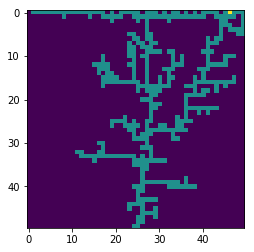

KeyboardInterrupt: 

In [6]:
n = 2*10**6
# n = 50
# n = 2

sim = Simulation(top_boundary=50, bottom_boundary=0,
                 left_boundary=0, right_boundary=50, 
                 prob_of_attachment=1)

# sim = Simulation()

a = np.zeros((sim.env.right_boundary, sim.env.top_boundary))
a = sim.env.grid
# plt.figure(figsize=(5,5))

t = 0
while True:
    if t%10000==0:
        print(t)
        clear_output(wait=True)
        plt.imshow(a)
        plt.show()
    sim.timestep()
    a = sim.env.grid
#     print(len(sim.env.walkers))
#     sleep(0.01)
#     clear_output(wait=True)
    t += 1

# for i in range(n):
#     if i%100000==0:
#         print('iteration ', i)
#     sim.timestep()

In [30]:
n = int(7*10**5)

sim = Simulation(top_boundary=50, bottom_boundary=0,
                 left_boundary=0, right_boundary=50, 
                 prob_of_attachment=1)

for i in range(n):
    if i%100000==0:
        print('iteration ', i)
    sim.timestep()

iteration  0
iteration  100000
iteration  200000
iteration  300000
iteration  400000
iteration  500000
iteration  600000


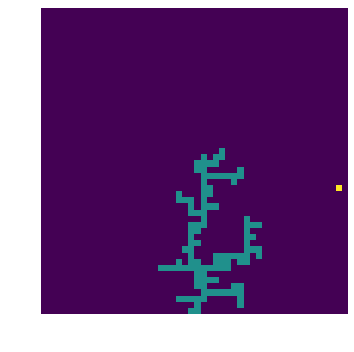

In [32]:
fig = plt.subplots(figsize=(5,5))
plt.imshow(sim.env.grid)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('off')

plt.tight_layout()
plt.savefig('MC_DLA_700K.pdf', bbox_inches='tight')
plt.show()

In [33]:
df = pd.DataFrame(sim.env.grid)
df.to_csv('MC_DLA_700K.csv')

In [9]:
n = 7*10**5

MC_results = {}

for p in [0.9, 0.7, 0.5, 0.3, 0.1]:
    sim = Simulation(top_boundary=50, bottom_boundary=0,
                 left_boundary=0, right_boundary=50, 
                 prob_of_attachment=p)
    for i in range(n):
        if i%100000==0:
            print(p,', iteration ', i)
        sim.timestep()
    df = pd.DataFrame(sim.env.grid)
    df.to_csv('MC_DLA_'+str(p)+'_700K.csv')
    MC_results[p] = sim.env.grid

0.9 , iteration  0
0.9 , iteration  100000
0.9 , iteration  200000
0.9 , iteration  300000
0.9 , iteration  400000
0.9 , iteration  500000
0.9 , iteration  600000
0.7 , iteration  0
0.7 , iteration  100000
0.7 , iteration  200000
0.7 , iteration  300000
0.7 , iteration  400000
0.7 , iteration  500000
0.7 , iteration  600000
0.5 , iteration  0
0.5 , iteration  100000
0.5 , iteration  200000
0.5 , iteration  300000
0.5 , iteration  400000
0.5 , iteration  500000
0.5 , iteration  600000
0.3 , iteration  0
0.3 , iteration  100000
0.3 , iteration  200000
0.3 , iteration  300000
0.3 , iteration  400000
0.3 , iteration  500000
0.3 , iteration  600000
0.1 , iteration  0
0.1 , iteration  100000
0.1 , iteration  200000
0.1 , iteration  300000
0.1 , iteration  400000
0.1 , iteration  500000
0.1 , iteration  600000


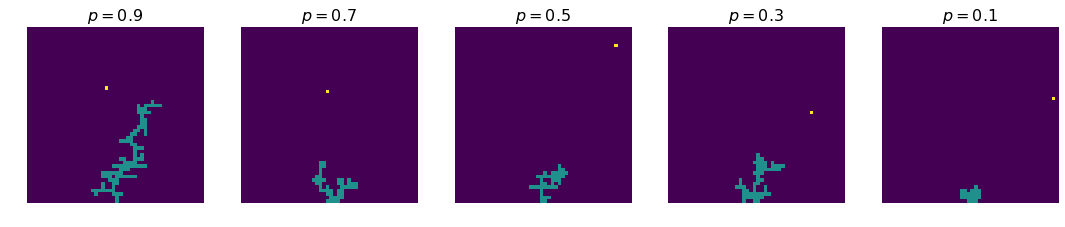

In [18]:
fig, [ax1,ax2,ax3, ax4, ax5] = plt.subplots(1,5,figsize=(15,3))

ax1.imshow(MC_results[0.9])
ax1.set_title('$p=0.9$', fontsize=16)
ax1.axis('off')

ax2.imshow(MC_results[0.7])
ax2.set_title('$p=0.7$', fontsize=16)
ax2.axis('off')

ax3.imshow(MC_results[0.5])
ax3.set_title('$p=0.5$', fontsize=16)
ax3.axis('off')

ax4.imshow(MC_results[0.3])
ax4.set_title('$p=0.3$', fontsize=16)
ax4.axis('off')

ax5.imshow(MC_results[0.1])
ax5.set_title('$p=0.1$', fontsize=16)
ax5.axis('off')

plt.tight_layout()
plt.savefig('MC_DLA_probs_700K.pdf', bbox_inches='tight')
plt.show()

In [71]:
def count_neighbors(grid, Nspace=50):
    in_object = []
    
    max_height = 50
                     
    for y in range(Nspace):
        for x in range(Nspace):
            if grid[y][x] == 0.5:
                in_object += [(y,x)]
                if y<max_height:
                    max_height = y
    
    candidates = []
    for cell in in_object:
        y = cell[0]
        x = cell[1]
        if (y+1, x) not in in_object and y+1<Nspace-1:
            candidates += [(y+1, x)]
        if (y-1, x) not in in_object:
            candidates += [(y-1, x)]
        if (y, (x+1)%Nspace) not in in_object:
            candidates += [(y, x+1)]
        if (y, x-1) not in in_object:
            candidates += [(y, x-1)]
    
    
    return len(candidates)/len(in_object), max_height

In [72]:
experiments = 10
n = 7*10**5
# n = 10000

probs = [0.9, 0.7, 0.5, 0.3, 0.1]

grids = {p:[] for p in probs}

for p in probs:
    for e in range(experiments):
        print('p ',p,', e ',e)
        sim = Simulation(top_boundary=50, bottom_boundary=0,
                     left_boundary=0, right_boundary=50, 
                     prob_of_attachment=p)
        for i in range(n):
            sim.timestep()
        
        df = pd.DataFrame(sim.env.grid)
        df.to_csv(f'grids/grid_{p}_{e}.csv')
        
        grids[p] += [sim.env.grid]
        


p  0.9 , e  0
p  0.9 , e  1
p  0.9 , e  2
p  0.9 , e  3
p  0.9 , e  4
p  0.9 , e  5
p  0.9 , e  6
p  0.9 , e  7
p  0.9 , e  8
p  0.9 , e  9
p  0.7 , e  0
p  0.7 , e  1
p  0.7 , e  2
p  0.7 , e  3
p  0.7 , e  4
p  0.7 , e  5
p  0.7 , e  6
p  0.7 , e  7
p  0.7 , e  8
p  0.7 , e  9
p  0.5 , e  0
p  0.5 , e  1
p  0.5 , e  2
p  0.5 , e  3
p  0.5 , e  4
p  0.5 , e  5
p  0.5 , e  6
p  0.5 , e  7
p  0.5 , e  8
p  0.5 , e  9
p  0.3 , e  0
p  0.3 , e  1
p  0.3 , e  2
p  0.3 , e  3
p  0.3 , e  4
p  0.3 , e  5
p  0.3 , e  6
p  0.3 , e  7
p  0.3 , e  8
p  0.3 , e  9
p  0.1 , e  0
p  0.1 , e  1
p  0.1 , e  2
p  0.1 , e  3
p  0.1 , e  4
p  0.1 , e  5
p  0.1 , e  6
p  0.1 , e  7
p  0.1 , e  8
p  0.1 , e  9


In [73]:
dens = []
height = []

for p in probs:
    p_dens = []
    p_height = []
    for e in range(experiments):
        res = count_neighbors(grids[p][e])
        p_dens += [res[0]]
        p_height += [res[1]]
    
    dens += [p_dens]
    height += [p_height]

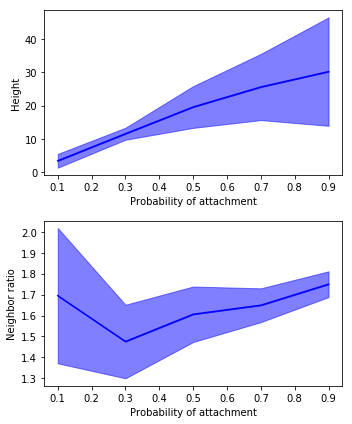

In [80]:
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(5,6))

avg = [abs(np.average(height[p])-49) for p in range(len(probs))]
std = [np.std(height[p]) for p in range(len(probs))]

ax1.plot(probs, avg, color='blue')
ax1.fill_between(probs, avg, np.array(avg)-np.array(std), color='blue', alpha=0.5)
ax1.fill_between(probs, avg, np.array(avg)+np.array(std), color='blue', alpha=0.5)
ax1.set_xlabel('Probability of attachment')
ax1.set_ylabel('Height')

avg = [np.average(dens[p]) for p in range(len(probs))]
std = [np.std(dens[p]) for p in range(len(probs))]

ax2.plot(probs, avg, color='blue')
ax2.fill_between(probs, avg, np.array(avg)-np.array(std), color='blue', alpha=0.5)
ax2.fill_between(probs, avg, np.array(avg)+np.array(std), color='blue', alpha=0.5)
ax2.set_xlabel('Probability of attachment')
ax2.set_ylabel('Neighbor ratio')
ax2.set_xticks(probs, probs)

plt.tight_layout()
plt.savefig('MC_height_dens.pdf', bbox_inches='tight')
plt.show()